In [235]:
%pip install datasets==2.17.0
%pip install openai
%pip install datasets
%pip install scikit-learn
%pip install matplotlib
%pip install numpy

^C
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/selinameyer/Desktop/Samy/Untitled/uncertainty-based-sampling/.venv/lib/python3.11/site-packages/pip/__main__.py", line 22, in <module>
    from pip._internal.cli.main import main as _main
  File "/Users/selinameyer/Desktop/Samy/Untitled/uncertainty-based-sampling/.venv/lib/python3.11/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/Users/selinameyer/Desktop/Samy/Untitled/uncertainty-based-sampling/.venv/lib/python3.11/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/Users/selinameyer/Desktop/Samy/Untitled/uncertainty-based-sampling/.venv/lib/python3.11/site-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_en

In [8]:
from openai import OpenAI
from math import exp
import math
import json
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from datasets import load_dataset, Dataset, DatasetDict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import logging

### Loading Datasets

In [2]:
client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY')) #Or enter your API Key gere
copa = load_dataset("super_glue", "copa")
wic = load_dataset("super_glue", "wic")
boolq = load_dataset("super_glue",  "boolq")

gpt_3 = "gpt-3.5-turbo-0125"
gpt_4 = "gpt-4-0125-preview"

/Users/selinameyer/Desktop/Samy/Untitled/uncertainty-based-sampling/.venv/lib/python3.11/site-packages/datasets/load.py:1454: FutureWarning: The repository for super_glue contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/super_glue
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


### Defining Functions

In [3]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }

    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

def plot_aggs(dat): 
   # Aggregate probabilities based on correctness
    correct_probs = dat[dat['correct_classification']]['1_prob']
    incorrect_probs = dat[~dat['correct_classification']]['1_prob']

    # Plot
    fig, ax = plt.subplots()
    ax.hist([correct_probs, incorrect_probs], bins=10, label=['Correct', 'Incorrect'], color=['green', 'red'])
    ax.set_title('Distribution of Probabilities for Correct and Incorrect Classifications')
    ax.set_xlabel('Probability (%)')
    ax.set_ylabel('Count')
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_calibration_curve(dat, correctness="correct_classification", prob="1_prob"):
    # Assuming 'correct_classification' column is a boolean indicating if the classification is correct
    # Convert boolean 'correct' to integer if necessary
    y_true = dat[correctness].astype(int)  # True labels
    prob_pos = dat[prob] / 100 # Predicted probabilities for the positive class

    # Compute the calibration curve
    # y_true are the true labels, prob_pos are the predicted probabilities
    prob_true, prob_pred = calibration_curve(y_true, prob_pos, n_bins=20, strategy='uniform')

    # Plot the calibration curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")  # Reference line
    ax.plot(prob_pred, prob_true, "s-", label="Model")

    ax.set_title('Calibration Curve')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')

    ax.legend()
    plt.tight_layout()
    plt.show()

In [175]:
def process_entries(dataset, max_entries, model_name, dataset_name, filename, few_shot=False, few_shot_prompt=None):
    """
    Processes entries from a dataset, obtains model completions, and saves to a CSV file.

    Parameters:
        dataset (dict): Dataset containing entries to process.
        max_entries (int): Maximum number of entries to process.
        model_name (str): Name of the model to use for completions.
        dataset_name (str): Specific dataset name for custom processing.
        filename (str): Filename for the output CSV.
        few_shot (bool): Flag to enable few-shot learning mode.
        few_shot_prompt (list): List of prompts for few-shot learning.

    Returns:
        DataFrame: A DataFrame containing processed entries and their model completions.
    """
    class_prompts = ""
    results = {}  # Dictionary to store the results.

    # Process each entry in the dataset up to the max_entries limit
    for i, entry in enumerate(dataset): # Stop if the maximum number of entries is reached
        if i < max_entries:
            if few_shot:
                results[i] = {
                    "idx": entry["idx"],
                    "true_label": entry["true_label"],
                    "zero_shot_label": entry["1_token"]
                }
            else:
                results[i] = {
                    "idx": entry["idx"],
                    "true_label": entry["label"],
                }

                # Set additional keys specific to the dataset
            set_keys(entry, results[i], dataset_name)

            # Generate the prompt using the provided function
            if few_shot:
                CLASSIFICATION_PROMPT = few_shot_prompt + [{"role": "user", "content": get_prompt(entry, dataset_name)}]

                API_RESPONSE = get_completion(
                    messages=CLASSIFICATION_PROMPT,
                    model=model_name,
                    logprobs=True,
                    top_logprobs=5,
                )

                    # Extract and store the top logprob results
                top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs
                for j, logprob in enumerate(top_two_logprobs, start=1):
                    results[i][f"{j}_token_few_shot"] = logprob.token
                    results[i][f"{j}_prob_few_shot"] = np.round(np.exp(logprob.logprob)*100, 2)
                    
            else:

                CLASSIFICATION_PROMPT = get_prompt(entry, dataset_name)

                API_RESPONSE = get_completion(
                    messages=[
                        {"role": "user", "content": CLASSIFICATION_PROMPT}],
                    model=model_name,
                    logprobs=True,
                    top_logprobs=5,
                )

                # Extract top logprobs
                top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs
                for j, logprob in enumerate(top_two_logprobs, start=1):
                    results[i][f"{j}_token"] = logprob.token
                    results[i][f"{j}_prob"] = np.round(np.exp(logprob.logprob)*100, 2)

    # Save results to CSV
        df = pd.DataFrame.from_dict(results, orient='index')
        df.to_csv(filename)
    return df

def process_escalation(dataset, dataset_name, filename, model_name=gpt_4, random=False):
    """
    Processes low-confidence entries from a dataset with a more powerful model, optionally using random sampling or a threshold-based selection.

    Parameters:
        dataset (dict): Dataset containing entries to process.
        dataset_name (str): Specific dataset name for custom processing.
        filename (str): Filename for the output CSV.
        model_name (str): Name of the model to use for completions.
        random (bool): Flag to enable random selection of entries.

    Returns:
        DataFrame: A DataFrame containing processed entries and their model completions.
    """
    results = {}  # Dictionary to store the results.

   # Calculate threshold-based counts for the probability criterion
    high_prob = len(dataset[dataset["1_prob"] >= 95])
    low_prob = len(dataset[dataset["1_prob"] < 95])
    # Generate a random permutation of indices based on probabilities
    arr = np.array([0] * high_prob + [1] * (low_prob))
    np.random.shuffle(arr)

    for i, entry in dataset.iterrows():

        results[i] = {
                "idx": entry["idx"],
                "true_label": entry["true_label"],
            }

        if random:
            # Random selection based on pre-shuffled array
            if arr[i] == 0:
                results[i]["1_token"] = entry["1_token"]
                results[i]["1_prob"] = entry["1_prob"]
            else:
                CLASSIFICATION_PROMPT = get_prompt(entry, dataset_name)

                # Simulate API call (replace with actual API call) TODO remove
                API_RESPONSE = get_completion(
                    messages=[{"role": "user", "content": CLASSIFICATION_PROMPT}],
                    model=model_name,
                    logprobs=True,
                    top_logprobs=5,
                )

                 # Extract top logprobs
                top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs
                for j, logprob in enumerate(top_two_logprobs, start=1):
                    results[i][f"{j}_token"] = logprob.token
                    results[i][f"{j}_prob"] = np.round(np.exp(logprob.logprob)*100, 2)
        else:
            # Selection based on probability threshold
            if entry["1_prob"] >= 95:
                results[i]["1_token"] = entry["1_token"]
                results[i]["1_prob"] = entry["1_prob"]
            else:
                CLASSIFICATION_PROMPT = get_prompt(entry, dataset_name)

                # Simulate API call (replace with actual API call)
                API_RESPONSE = get_completion(
                    messages=[{"role": "user", "content": CLASSIFICATION_PROMPT}],
                    model=model_name,
                    logprobs=True,
                    top_logprobs=5,
                )

                # Extract top logprobs
                top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs
                for j, logprob in enumerate(top_two_logprobs, start=1):
                    results[i][f"{j}_token"] = logprob.token
                    results[i][f"{j}_prob"] = np.round(np.exp(logprob.logprob)*100, 2)

    # Save results to CSV
    df = pd.DataFrame.from_dict(results, orient='index')
    df.to_csv(filename)
    return df

def get_prompt(entry, dataset_name):
    """
    Generates a classification prompt based on the dataset name and specific entry.

    Parameters:
        entry (dict): A single data entry from the dataset.
        dataset_name (str): The name of the dataset to tailor the prompt.

    Returns:
        str: The formatted classification prompt based on dataset-specific requirements.
    """
    if dataset_name == "wic":
        return f"""Determine whether the word {entry["word"]} is used in the same sense in the following two contexts. Return 1 or 0 and nothing else. 
        Context 1: {entry["sentence1"]} Context 2: {entry["sentence2"]} Sense match:"""
    elif dataset_name == "copa":
        return f"""Return 0 if Alternative 1 is true and 1 if Alterntive 2 is true. Return only 0 or 1 and nothing else. Premise: {entry["premise"]}  Question: What's the {entry["question"]} of this?
        Alternative 1: {entry["choice1"]} Alternative 2: {entry["choice2"]} Correct Alternative: """
    elif dataset_name == "boolq":
        return f"""Return 0 for No and 1 for Yes. Return only 0 or 1 and nothing else. 
        Passage: \"{entry["passage"]}\" Question: \"{entry["question"]}\" Answer:"""

def set_keys(entry, result, dataset_name):
    """
    Sets specific keys in the results dictionary based on the dataset type.

    Parameters:
        entry (dict): A single data entry from the dataset.
        result (dict): A dictionary where dataset-specific keys and values will be set.
        dataset_name (str): The name of the dataset to tailor the keys accordingly.
    """
    
    if dataset_name == "wic":
        result.update({
            "word": entry["word"],
            "sentence1": entry["sentence1"],
            "sentence2": entry["sentence2"]
        })
    elif dataset_name == "copa":
        result.update({
        "premise": entry["premise"],
        "question": entry["question"],
        "choice1": entry["choice1"],
        "choice2": entry["choice2"]
        })
    elif dataset_name == "boolq":
        result.update({
        "passage": entry["passage"],
        "question": entry["question"]  
        })


def write_ids(df, name):
    """
    Writes a list of IDs from a DataFrame to a text file.

    Parameters:
        df (DataFrame): DataFrame containing the IDs to write.
        name (str): Filename under which to save the list of IDs.
    """
    idx_list = df["idx"].tolist()
    with open(f'ids/{name}.txt', 'w') as file:
        for item in idx_list:
            file.write(f"{item}\n")
        

def construct_few_shot_prompt(dataset_name, dataset, few_shot_type="random", model=gpt_3):
    """
    Constructs a few-shot prompt using selected samples from a dataset.

    Parameters:
        dataset_name (str): The dataset name.
        dataset (DataFrame): The dataset from which to select few-shot samples.
        few_shot_type (str): Type of few-shot sampling ('random' or 'top').
        model (str): Model version used for the sampling.

    Returns:
        list: A list of prompt dictionaries formatted for use in model completion.
    """
    if model != gpt_3:
        if few_shot_type=="random":
            ids = pd.read_csv(f"ids/{dataset_name}_random_few_shot_gpt_4.csv")
            few_shot = dataset[dataset["idx"].isin(ids["idx"])]
            #print(len(few_shot))
        else:
            ids = pd.read_csv(f"ids/{dataset_name}_top_few_shot_gpt_4.csv")
            few_shot = dataset[dataset["idx"].isin(ids["idx"])]
            #few_shot = dataset[dataset["idx"].isin(idx_list)]
            #print(len(few_shot))
    else:
        if few_shot_type=="random":
            ids = pd.read_csv(f"ids/{dataset_name}_random_few_shot.csv")
            few_shot = dataset[dataset["idx"].isin(ids["idx"])]
            #print(len(few_shot))
        else:
            ids = pd.read_csv(f"ids/{dataset_name}_top_few_shot.csv")
            few_shot = dataset[dataset["idx"].isin(ids["idx"])]
            #print(len(few_shot))
    
    i = 0
    few_shot_prompt = []

    while i < 10:
        sample = few_shot.iloc[i]

        few_shot_prompt.append({"role": "user", "content": get_prompt(sample, dataset_name)})
        few_shot_prompt.append({"role": "assistant", "content": str(sample['1_token'])})
        
        i += 1
    return few_shot_prompt

def get_few_shot_classifications(dataset_name, dataset, few_shot_type="random", model_name=gpt_3):
    """
    Classifies a test dataset using few-shot learning prompts and saves the results.

    Parameters:
        dataset_name (str): The name of the dataset to classify
        dataset (DataFrame): The dataset to classify.
        few_shot_type (str): Specifies the type of few-shot learning (either "random" or "top").
        model_name (str): The model version to use for classifications.

    Returns:
        DataFrame: A DataFrame containing classified entries, annotated with model responses.
    """
    if model_name==gpt_3:
        with open(f'ids/{dataset_name}_test_ids.txt', 'r') as file:
            idx_list = [int(line.strip()) for line in file]
    else:
        with open(f'ids/{dataset_name}_test_gpt_4_ids.txt', 'r') as file:
            idx_list = [int(line.strip()) for line in file]
    
    test_df = dataset[dataset["idx"].isin(idx_list)]
    train_df = dataset[~dataset["idx"].isin(idx_list)]
    few_shot_prompt = construct_few_shot_prompt(dataset_name, dataset, few_shot_type, model_name)
    #print(few_shot_prompt)

    test_dataset = Dataset.from_pandas(test_df)
    train_dataset = Dataset.from_pandas(train_df)
    dataset_dict = DatasetDict({ # this is because process entries automatically chooses `train` data to predict on. We want to predict on the test-data, so we are defining it as `train` in this case.
        'train': train_dataset,
        'test': test_dataset
        })
    
    filtered_dataset_classified = process_entries(dataset_dict["test"], 300, model_name, dataset_name, f"classifs/{dataset_name}_{few_shot_type}_few_shot_classified_{model_name}.csv",
                    few_shot=True, few_shot_prompt=few_shot_prompt)
    
    return filtered_dataset_classified

def get_gpt_4_data(dataset_name, dataset):
    with open(f'ids/{dataset_name}_test_gpt_4_ids.txt', 'r') as file:
            idx_list_test = [int(line.strip()) for line in file]
    with open(f'ids/{dataset_name}_train_gpt_4_ids.txt', 'r') as file:
            idx_list_train = [int(line.strip()) for line in file]
    test_df = dataset[dataset["idx"].isin(idx_list_test)]
    train_df = dataset[dataset["idx"].isin(idx_list_train)]
    test_dataset = Dataset.from_pandas(test_df.rename(columns={"true_label":"label"}))
    train_dataset = Dataset.from_pandas(train_df.rename(columns={"true_label":"label"}))
    dataset_dict = DatasetDict({ 
        'train': train_dataset,
        'test': test_dataset
        })
    return dataset_dict
    

# We delivered the ids of all few-shot examples we used during our experiments with this code.
#  If you want to create your own few-shot examples based on your own predictions, you can run the code below
'''def save_few_shot_samples(dataset, dataset_name, model_name):
    """
    Selects and saves few-shot samples based on their probability scores.

    Parameters:
        dataset (DataFrame): The dataset from which to select samples.
        dataset_name (str): The name of the dataset.
        model_name (str): The model version to be used in selecting few-shot samples.
    """

    if model_name==gpt_3:
        with open(f'ids/{dataset_name}_train_ids.txt', 'r') as file:
            idx_list = [int(line.strip()) for line in file]
    else: 
        with open(f'ids/{dataset_name}_train_gpt_4_ids.txt', 'r') as file:
            idx_list = [int(line.strip()) for line in file]

    train = dataset[dataset["idx"].isin(idx_list)]
    print(len(train))

    train_pos = train[train["1_token"].astype(int) == 1]
    print(len(train_pos))
    train_neg = train[train["1_token"].astype(int) == 0]
    print(len(train_neg))

    random_pos = train_pos.sample(5)
    random_neg = train_neg.sample(5)

    top_pos = train_pos.sort_values(by="1_prob").tail(5)
    top_neg = train_neg.sort_values(by="1_prob").tail(5)

    top = pd.concat([top_neg, top_pos]).sample(frac=1)
    random = pd.concat([random_neg, random_pos]).sample(frac=1)

    if model_name == gpt_3:
        write_ids(top, f"ids/{dataset_name}_top_few_shot_ids")
        write_ids(random, f"ids/{dataset_name}_random_few_shot_ids")
    else: 
        write_ids(top, f"ids/{dataset_name}_top_few_shot_gpt_4_ids")
        write_ids(random, f"ids/{dataset_name}_random_few_shot_gpt_4_ids")'''

'def save_few_shot_samples(dataset, dataset_name, model_name):\n    """\n    Selects and saves few-shot samples based on their probability scores.\n\n    Parameters:\n        dataset (DataFrame): The dataset from which to select samples.\n        dataset_name (str): The name of the dataset.\n        model_name (str): The model version to be used in selecting few-shot samples.\n    """\n\n    if model_name==gpt_3:\n        with open(f\'ids/{dataset_name}_train_ids.txt\', \'r\') as file:\n            idx_list = [int(line.strip()) for line in file]\n    else: \n        with open(f\'ids/{dataset_name}_train_gpt_4_ids.txt\', \'r\') as file:\n            idx_list = [int(line.strip()) for line in file]\n\n    train = dataset[dataset["idx"].isin(idx_list)]\n    print(len(train))\n\n    train_pos = train[train["1_token"].astype(int) == 1]\n    print(len(train_pos))\n    train_neg = train[train["1_token"].astype(int) == 0]\n    print(len(train_neg))\n\n    random_pos = train_pos.sample(5)\n    r

### API Calls - Initial Classification

In [ ]:
wic_classified = process_entries(wic["train"], 300, gpt_3, dataset_name="wic", filename="classifs/wic_zero_shot-gpt-3.csv")
copa_classified = process_entries(copa["train"], 300, gpt_3, dataset_name="copa", filename="classifs/copa_zero_shot-gpt-3.csv")
boolq_classified = process_entries(boolq["train"], 300, gpt_3, dataset_name="boolq", filename="classifs/boolq_zero_shot-gpt-3.csv")

In [37]:
wic_classified = pd.read_csv("classifs/wic_zero_shot-gpt-3.csv", index_col="Unnamed: 0")
boolq_classified = pd.read_csv("classifs/copa_zero_shot-gpt-3.csv", index_col="Unnamed: 0")
copa_classified = pd.read_csv("classifs/boolq_zero_shot-gpt-3.csv", index_col="Unnamed: 0")

#### Analysis

In [38]:
wic_classified["correct_classification"] = wic_classified['true_label'] == wic_classified['1_token'].astype('int64')
copa_classified["correct_classification"] = copa_classified['true_label'] == copa_classified['1_token'].astype('int64')
boolq_classified["correct_classification"] = boolq_classified['true_label'] == boolq_classified['1_token'].astype('int64')

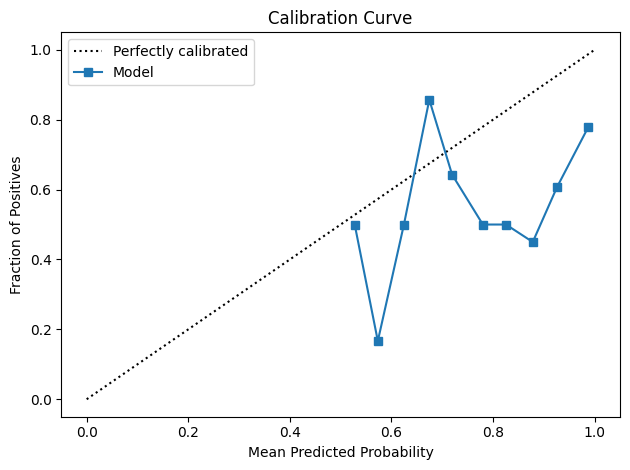

(0.6883666274970623, 0.6790741319987488, 0.6791224796322425, None)

In [39]:
plot_calibration_curve(wic_classified)
precision_recall_fscore_support(wic_classified["true_label"], wic_classified["1_token"].astype('int64'), average="macro")

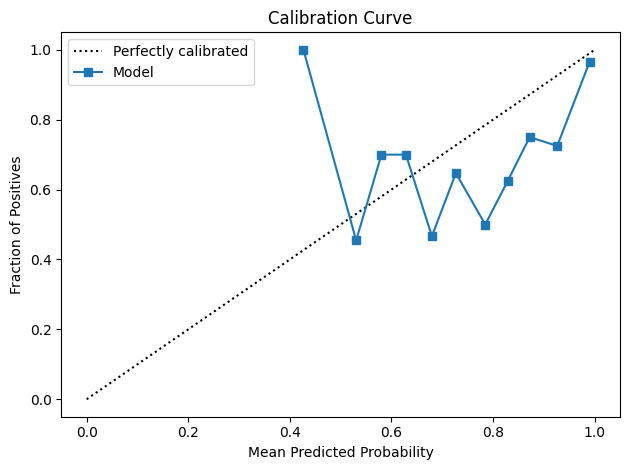

(0.8327067669172933, 0.8320825515947468, 0.832264121420748, None)

In [40]:
plot_calibration_curve(copa_classified)
precision_recall_fscore_support(copa_classified["true_label"], copa_classified["1_token"].astype('int64'), average="macro")

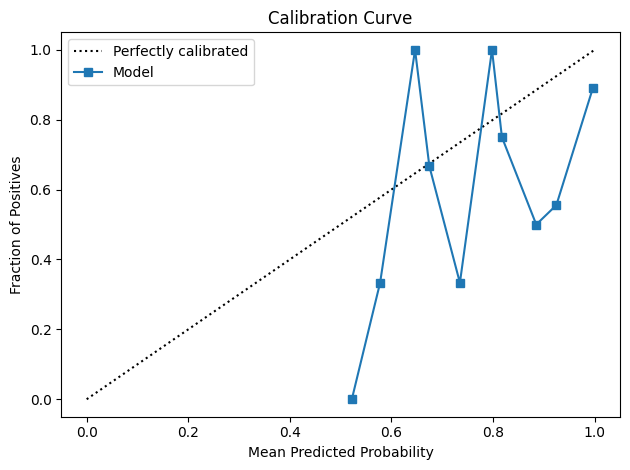

(0.844368986983588, 0.844368986983588, 0.844368986983588, None)

In [41]:
plot_calibration_curve(boolq_classified)
precision_recall_fscore_support(boolq_classified["true_label"], boolq_classified["1_token"].astype('int64'), average="macro")

### Few Shot classification


In [ ]:
'''save_few_shot_samples(wic_classified, "wic", gpt_3)
save_few_shot_samples(copa_classified, "copa", gpt_3)
save_few_shot_samples(boolq_classified, "boolq", gpt_3)'''

In [ ]:
wic_random_few_shot = get_few_shot_classifications("wic", wic_classified, "random", gpt_3)
wic_top_few_shot = get_few_shot_classifications("wic", wic_classified, "top", gpt_3)

copa_random_few_shot = get_few_shot_classifications("copa", copa_classified, "random", gpt_3)
copa_top_few_shot = get_few_shot_classifications("copa", copa_classified, "top", gpt_3)

boolq_random_few_shot = get_few_shot_classifications("boolq", boolq_classified, "random", gpt_3)
boolq_top_few_shot = get_few_shot_classifications("boolq", boolq_classified, "top", gpt_3)

#### Analysis

In [62]:
wic_random_few_shot["correct_classification"] = wic_random_few_shot['true_label'] == wic_random_few_shot['1_token_few_shot']
wic_top_few_shot["correct_classification"] = wic_top_few_shot['true_label'] == wic_top_few_shot['1_token_few_shot']

copa_random_few_shot["correct_classification"] = copa_random_few_shot['true_label'] == copa_random_few_shot['1_token_few_shot']
copa_top_few_shot["correct_classification"] = copa_top_few_shot['true_label'] == copa_top_few_shot['1_token_few_shot']

boolq_random_few_shot["correct_classification"] = boolq_random_few_shot['true_label'] == boolq_random_few_shot['1_token_few_shot']
boolq_top_few_shot["correct_classification"] = boolq_top_few_shot['true_label'] == boolq_top_few_shot['1_token_few_shot']

In [63]:
print("WIC results:")
print("Zero-shot:",precision_recall_fscore_support(wic_random_few_shot["true_label"], wic_random_few_shot["zero_shot_label"].astype(int), average="macro"))
print("random few-shot:", precision_recall_fscore_support(wic_random_few_shot["true_label"], wic_random_few_shot["1_token_few_shot"].astype(int), average="macro"))
print("top few-shot:", precision_recall_fscore_support(wic_top_few_shot["true_label"], wic_top_few_shot["1_token_few_shot"].astype(int), average="macro"))

WIC results:
Zero-shot: (0.691468253968254, 0.6781173092698933, 0.6773549201009251, None)
random few-shot: (0.6452192667145937, 0.6449958982772764, 0.6414049945157259, None)
top few-shot: (0.6101164797238999, 0.6046964725184578, 0.5933038923693129, None)


In [64]:
print("COPA results:")
print("Zero-shot:", precision_recall_fscore_support(copa_random_few_shot["true_label"], copa_random_few_shot["zero_shot_label"].astype(int), average="macro"))
print("random few-shot:", precision_recall_fscore_support(copa_random_few_shot["true_label"], copa_random_few_shot["1_token_few_shot"].astype(int), average="macro"))
print("top few-shot:", precision_recall_fscore_support(copa_top_few_shot["true_label"], copa_top_few_shot["1_token_few_shot"].astype(int), average="macro"))

COPA results:
Zero-shot: (0.8437709086043088, 0.8427770859277708, 0.8430385946944818, None)
random few-shot: (0.8847935503986459, 0.8842287849137165, 0.8833216654998833, None)
top few-shot: (0.9119385607451524, 0.9091353851627824, 0.9097100689993423, None)


In [65]:
print("Boolq results:")
print("Zero-shot:", precision_recall_fscore_support(boolq_random_few_shot["true_label"], boolq_random_few_shot["zero_shot_label"].astype(int), average="macro"))
print("random few-shot:", precision_recall_fscore_support(boolq_random_few_shot["true_label"], boolq_random_few_shot["1_token_few_shot"].astype(int), average="macro"))
print("top few-shot:", precision_recall_fscore_support(boolq_top_few_shot["true_label"], boolq_top_few_shot["1_token_few_shot"].astype(int), average="macro"))

Boolq results:
Zero-shot: (0.797962648556876, 0.7881773399014778, 0.7916666666666667, None)
random few-shot: (0.8357963875205254, 0.8357963875205254, 0.8357963875205254, None)
top few-shot: (0.8555194805194806, 0.8596059113300492, 0.8572011423908609, None)


### GPT-4 Initial Classification

In [130]:
wic_gpt_4 = get_gpt_4_data("wic", wic["train"].to_pandas())
copa_gpt_4 = get_gpt_4_data("copa", copa["train"].to_pandas())
boolq_gpt_4 = get_gpt_4_data("boolq", boolq["train"].to_pandas())

In [ ]:
wic_gpt_4_classified_train = process_entries(wic_gpt_4["train"], 50, gpt_4, "wic", "classifs/_wic_train_classified_gpt_4.csv")
copa_gpt_4_classified_train = process_entries(copa_gpt_4["train"], 50, gpt_4,"copa", "classifs/copa_train_classified_gpt_4.csv")
boolq_gpt_4_classified_train = process_entries(boolq_gpt_4["train"], 50, gpt_4,"boolq", "classifs/boolq_train_classified_gpt_4.csv")

In [ ]:
wic_gpt_4_classified_test = process_entries(wic_gpt_4["test"], 50, gpt_4, "wic", "classifs/_wic_test_classified_gpt_4.csv")
copa_gpt_4_classified_test = process_entries(copa_gpt_4["test"], 50, gpt_4,"copa", "classifs/copa_test_classified_gpt_4.csv")
boolq_gpt_4_classified_test = process_entries(boolq_gpt_4["test"], 50, gpt_4,"boolq", "classifs/boolq_test_classified_gpt_4.csv")

#### Analysis

In [135]:
wic_gpt_4_classified_test["correct_classification"] = wic_gpt_4_classified_test['true_label'] == wic_gpt_4_classified_test['1_token'].astype(int)
copa_gpt_4_classified_test["correct_classification"] = copa_gpt_4_classified_test['true_label'] == copa_gpt_4_classified_test['1_token'].astype(int)
boolq_gpt_4_classified_test["correct_classification"] = boolq_gpt_4_classified_test['true_label'] == boolq_gpt_4_classified_test['1_token'].astype(int)

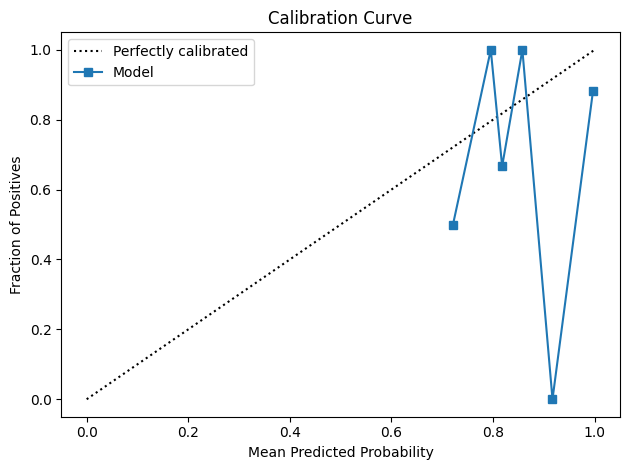

(0.8389694041867954, 0.8389694041867954, 0.8389694041867954, None)

In [105]:
plot_calibration_curve(wic_gpt_4_classified_test)
precision_recall_fscore_support(wic_gpt_4_classified_test["true_label"], wic_gpt_4_classified_test["1_token"].astype(int), average="macro")

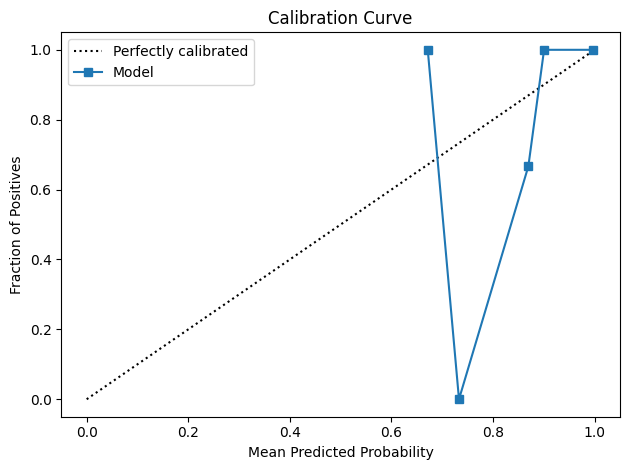

(0.9565217391304348, 0.9655172413793103, 0.9594155844155845, None)

In [136]:
plot_calibration_curve(copa_gpt_4_classified_test)
precision_recall_fscore_support(copa_gpt_4_classified_test["true_label"], copa_gpt_4_classified_test["1_token"].astype(int), average="macro")

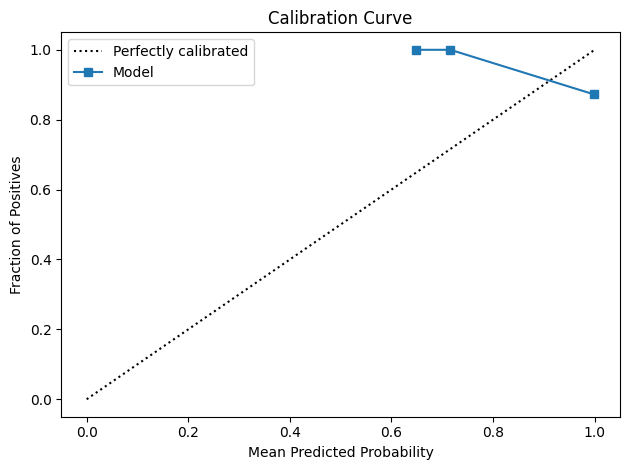

(0.8828522920203735, 0.8702791461412152, 0.875, None)

In [107]:
plot_calibration_curve(boolq_gpt_4_classified_test)
precision_recall_fscore_support(boolq_gpt_4_classified_test["true_label"], boolq_gpt_4_classified_test["1_token"].astype(int), average="macro")

### GPT-4 Few Shot Classification

In [163]:
combined_wic_gpt_4 = pd.concat([wic_gpt_4_classified_train, wic_gpt_4_classified_test])
combined_copa_gpt_4 = pd.concat([copa_gpt_4_classified_train, copa_gpt_4_classified_test])
combined_boolq_gpt_4 = pd.concat([boolq_gpt_4_classified_train, boolq_gpt_4_classified_test])

In [ ]:
wic_random_few_shot_gpt_4 = get_few_shot_classifications("wic", combined_wic_gpt_4, "random", gpt_4)
wic_top_few_shot_gpt_4 = get_few_shot_classifications("wic", combined_wic_gpt_4, "top", gpt_4)

copa_random_few_shot_gpt_4 = get_few_shot_classifications("copa", combined_copa_gpt_4, "random", gpt_4)
copa_top_few_shot_gpt_4 = get_few_shot_classifications("copa", combined_copa_gpt_4, "top", gpt_4)

boolq_random_few_shot_gpt_4 = get_few_shot_classifications("boolq", combined_boolq_gpt_4, "random", gpt_4)
boolq_top_few_shot_gpt_4 = get_few_shot_classifications("boolq", combined_boolq_gpt_4, "top", gpt_4)

In [165]:
wic_random_few_shot_gpt_4["correct_classification"] = wic_random_few_shot_gpt_4['true_label'] == wic_random_few_shot_gpt_4['1_token_few_shot'].astype(int)
wic_top_few_shot_gpt_4["correct_classification"] = wic_top_few_shot_gpt_4['true_label'] == wic_top_few_shot_gpt_4['1_token_few_shot'].astype(int)

copa_random_few_shot_gpt_4["correct_classification"] = copa_random_few_shot_gpt_4['true_label'] == copa_random_few_shot_gpt_4['1_token_few_shot'].astype(int)
copa_top_few_shot_gpt_4["correct_classification"] = copa_top_few_shot_gpt_4['true_label'] == copa_top_few_shot_gpt_4['1_token_few_shot'].astype(int)

boolq_random_few_shot_gpt_4["correct_classification"] = boolq_random_few_shot_gpt_4['true_label'] == boolq_random_few_shot_gpt_4['1_token_few_shot'].astype(int)
boolq_top_few_shot_gpt_4["correct_classification"] = boolq_top_few_shot_gpt_4['true_label'] == boolq_top_few_shot_gpt_4['1_token_few_shot'].astype(int)

#### Analysis

In [166]:
print("Zero-shot: ", precision_recall_fscore_support(wic_random_few_shot_gpt_4["true_label"], wic_random_few_shot_gpt_4["zero_shot_label"].astype(int), average="macro"))
print("Random few-shot: ", precision_recall_fscore_support(wic_random_few_shot_gpt_4["true_label"], wic_random_few_shot_gpt_4["1_token_few_shot"].astype(int), average="macro"))
print("top few-shot: ", precision_recall_fscore_support(wic_top_few_shot_gpt_4["true_label"], wic_top_few_shot_gpt_4["1_token_few_shot"].astype(int), average="macro"))

Zero-shot:  (0.8389694041867954, 0.8389694041867954, 0.8389694041867954, None)
Random few-shot:  (0.8555008210180624, 0.8486312399355878, 0.8397435897435898, None)
top few-shot:  (0.8701298701298701, 0.8671497584541064, 0.8599439775910365, None)


In [174]:
print("Zero-shot: ", precision_recall_fscore_support(copa_random_few_shot_gpt_4["true_label"], copa_random_few_shot_gpt_4["zero_shot_label"].astype(int), average="macro"))
print("Random few-shot: ", precision_recall_fscore_support(copa_random_few_shot_gpt_4["true_label"], copa_random_few_shot_gpt_4["1_token_few_shot"].astype(int), average="macro"))
print("top few-shot", precision_recall_fscore_support(copa_top_few_shot_gpt_4["true_label"], copa_top_few_shot_gpt_4["1_token_few_shot"].astype(int), average="macro"))

Zero-shot:  (0.9565217391304348, 0.9655172413793103, 0.9594155844155845, None)
Random few-shot:  (0.9772727272727273, 0.9827586206896552, 0.9796001631986944, None)
top few-shot (0.9772727272727273, 0.9827586206896552, 0.9796001631986944, None)


In [173]:
boolq_random_few_shot_gpt_4["1_token_few_shot"].replace({"I":-1}, inplace=True)
print("Zero-shot: ", precision_recall_fscore_support(boolq_random_few_shot_gpt_4["true_label"], boolq_random_few_shot_gpt_4["zero_shot_label"].astype(int), average="macro"))
print("Random few-shot: ", precision_recall_fscore_support(boolq_random_few_shot_gpt_4["true_label"], boolq_random_few_shot_gpt_4["1_token_few_shot"].astype(int), average="macro"))
print("top few-shot: ", precision_recall_fscore_support(boolq_top_few_shot_gpt_4["true_label"], boolq_top_few_shot_gpt_4["1_token_few_shot"].astype(int), average="macro"))

Zero-shot:  (0.8828522920203735, 0.8702791461412152, 0.875, None)
Random few-shot:  (0.8828522920203735, 0.8702791461412152, 0.875, None)
top few-shot:  (0.8404074702886248, 0.8292282430213465, 0.8333333333333334, None)


In [ ]:
wic_test_full = pd.read_csv("train_test_sets/wic_test.csv")

### Escalation

In [86]:
wic_classified = pd.read_csv("classifs/wic_zero_shot-gpt-3.csv", index_col="Unnamed: 0")
boolq_classified = pd.read_csv("classifs/boolq_zero_shot-gpt-3.csv", index_col="Unnamed: 0")
copa_classified = pd.read_csv("classifs/copa_zero_shot-gpt-3.csv", index_col="Unnamed: 0")

In [ ]:
wic_random_escalation = process_escalation(wic_classified, "wic", "classifs/wic_random_escalation_results.csv",
                                           gpt_4, True)
wic_escalation = process_escalation(wic_classified, "wic", "classifs/wic_escalation_results.csv",
                                           gpt_4, False)

copa_random_escalation = process_escalation(copa_classified, "copa", "classifs/copa_random_escalation_results.csv",
                                           gpt_4, True)
copa_escalation = process_escalation(copa_classified, "copa", "copa_escalation_results.csv",
                                           gpt_4, False)

boolq_random_escalation = process_escalation(boolq_classified, "boolq", "classifs/boolq_random_escalation_results.csv",
                                           gpt_4, True)
boolq_escalation = process_escalation(boolq_classified, "boolq", "classifs/boolq_escalation_results.csv",
                                           gpt_4, False)

In [90]:
print(precision_recall_fscore_support(wic_classified["true_label"], wic_classified["1_token"].astype(int), average="macro"))
print(precision_recall_fscore_support(wic_random_escalation["true_label"], wic_random_escalation["1_token"].astype(int), average="macro"))
print(precision_recall_fscore_support(wic_escalation["true_label"], wic_escalation["1_token"].astype(int), average="macro"))

(0.6883666274970623, 0.6790741319987488, 0.6791224796322425, None)
(0.7215995440729484, 0.7084990392778945, 0.7089007865386592, None)
(0.8035300925925926, 0.7812458108047724, 0.7832345081487768, None)


In [91]:
print(precision_recall_fscore_support(copa_classified["true_label"], copa_classified["1_token"].astype(int), average="macro"))
print(precision_recall_fscore_support(copa_random_escalation["true_label"], copa_random_escalation["1_token"].astype(int), average="macro"))
print(precision_recall_fscore_support(copa_escalation["true_label"], copa_escalation["1_token"].astype(int), average="macro"))

(0.8399359743897559, 0.8399359743897559, 0.8399359743897559, None)
(0.905126140633387, 0.9026944110977724, 0.9030910609857978, None)
(0.9666207386994977, 0.9667867146858744, 0.9666607396870555, None)


In [92]:
print(precision_recall_fscore_support(boolq_classified["true_label"], boolq_classified["1_token"].astype(int), average="macro"))
print(precision_recall_fscore_support(boolq_random_escalation["true_label"], boolq_random_escalation["1_token"].astype(int), average="macro"))
print(precision_recall_fscore_support(boolq_escalation["true_label"], boolq_escalation["1_token"].astype(int), average="macro"))

(0.844368986983588, 0.844368986983588, 0.844368986983588, None)
(0.854641598119859, 0.8558290888511602, 0.8552242846549512, None)
(0.8726655348047538, 0.8726655348047538, 0.8726655348047538, None)
